# Sample Based Interior/Edge Segmentation for 2D Data

---

Classifies each pixel as either Cell Edge, Cell Interior, or Background.

There are 2 different Cell Edge classes (Cell-Cell Boundary and Cell-Background Boundary)

In [1]:
import os
import errno

import numpy as np

import deepcell
from deepcell.utils.data_utils import get_data
from tensorflow.keras.utils import get_file

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [2]:
def load_data(path, mode, test_size=0.2, seed=0):
    """Loads dataset.
    Args:
         test_size (float): fraction of data to reserve as test data
        seed (int): the seed for randomly shuffling the dataset
    Returns:
           tuple: (x_train, y_train), (x_test, y_test).
    """
    basepath = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))
    prefix = path.split(os.path.sep)[:-1]
    data_dir = os.path.join(basepath, *prefix) if prefix else basepath
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    elif not os.path.isdir(data_dir):
        raise IOError('{} exists but is not a directory'.format(data_dir))

    train_dict, test_dict = get_data(
        path,
        mode=mode,
        test_size=test_size,
        seed=seed)
    x_train, y_train = train_dict['X'], train_dict['y']
    x_test, y_test = test_dict['X'], test_dict['y']
    return (x_train, y_train), (x_test, y_test)

## Load the data

### Download the data from `deepcell.datasets`

`deepcell.datasets` provides access to a set of annotated live-cell imaging datasets which can be used for training cell segmentation and tracking models.
All dataset objects share the `load_data()` method, which allows the user to specify the name of the file (`path`), the fraction of data reserved for testing (`test_size`) and a `seed` which is used to generate the random train-test split.
Metadata associated with the dataset can be accessed through the `metadata` attribute.

In [3]:
# Have to stack the batches together

file = np.load('../train.npz')

In [4]:
file['X'].shape

(440, 100, 530, 530, 1)

In [5]:
X = np.vstack(file['X'])

In [6]:
X = X[0:-1:150]

In [7]:
print(X.shape)

(294, 530, 530, 1)


In [8]:
y = np.vstack(file['y'])[0:-1:150]
print(y.shape)

(294, 530, 530, 1)


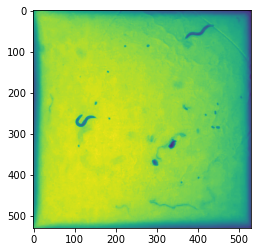

In [9]:
import matplotlib.pyplot as plt
plt.imshow(X[49])

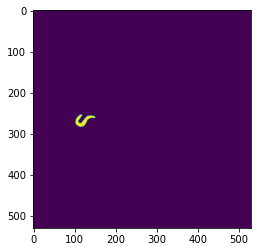

In [10]:
plt.imshow(y[49])

In [11]:
# Save it as seg_train.npz

np.savez("../seg_train.npz", X=X, y=y)

### Set up filepath constants

In [12]:
data = np.load('../seg_train.npz')

(X_train, y_train), (X_test, y_test) = load_data('../seg_train.npz', mode='sample')
print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))

X.shape: (235, 530, 530, 1)
y.shape: (235, 530, 530, 1)


In [13]:
# Set up other required filepaths

PREFIX = 'test'

ROOT_DIR = '../seg_train_0816'  
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

## Create the Foreground/Background FeatureNet Model

Here we instantiate two `FeatureNet` models from `deepcell.model_zoo` for foreground/background separation as well as the interior/edge segmentation.

In [14]:
norm_method = 'std'  # data normalization
receptive_field = 120  # should be adjusted for the scale of the data
n_skips = 1  # number of skip-connections (only for FC training)

In [15]:
# pixelwise transform settings
dilation_radius = 1  # change dilation radius for edge dilation
separate_edge_classes = True  # break edges into cell-background edge, cell-cell edge
pixelwise_kwargs = {
    'dilation_radius': dilation_radius,
    'separate_edge_classes': separate_edge_classes,
}

In [16]:
from deepcell import model_zoo

fgbg_model = model_zoo.bn_feature_net_2D(
    n_features=2,  # segmentation mask (is_cell, is_not_cell)
    norm_method=norm_method,
    receptive_field=receptive_field,
    n_channels=X_train.shape[-1])

## Prepare for training

### Set up training parameters.

There are a number of tunable hyper parameters necessary for training deep learning models:

**model_name**: Incorporated into any files generated during the training process.

**n_epoch**: The number of complete passes through the training dataset.

**lr**: The learning rate determines the speed at which the model learns. Specifically it controls the relative size of the updates to model values after each batch.

**optimizer**: The TensorFlow module [tf.keras.optimizers](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) offers optimizers with a variety of algorithm implementations. DeepCell typically uses the Adam or the SGD optimizers.

**lr_sched**: A learning rate scheduler allows the learning rate to adapt over the course of model training. Typically a larger learning rate is preferred during the start of the training process, while a small learning rate allows for fine-tuning during the end of training.

**batch_size**: The batch size determines the number of samples that are processed before the model is updated. The value must be greater than one and less than or equal to the number of samples in the training dataset.

In [17]:
from tensorflow.keras.optimizers import SGD
from deepcell.utils.train_utils import rate_scheduler

fgbg_model_name = 'conv_fgbg_model'
pixelwise_model_name = 'conv_edgeseg_model'

n_epoch = 5  # Number of training epochs

lr = 0.01
fgbg_optimizer = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
pixelwise_optimizer = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)

lr_sched = rate_scheduler(lr=lr, decay=0.99)

batch_size = 1  # fully convolutional training uses 1 image per batch

### Create the DataGenerators

The `ImageFullyConvDataGenerator` outputs a raw image (`X`) with it's labeled annotation mask (`y`). Additionally, it can apply a transform to `y` to change the task the model learns. Below we generate 2 training and validation data sets for both the foreground/background model and the pixelwise model.

In [18]:
test_size = 0.2
seed = 0

In [19]:
from deepcell.image_generators import ImageFullyConvDataGenerator

datagen = ImageFullyConvDataGenerator(
    rotation_range=180,
    zoom_range=(.8, 1.2),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = ImageFullyConvDataGenerator()

In [20]:
# Create the foreground/background data iterators

fgbg_train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    skip=n_skips,
    transform='fgbg',
    batch_size=batch_size)

fgbg_val_data = datagen_val.flow(
    {'X': X_test, 'y': y_test},
    seed=seed,
    skip=n_skips,
    transform='fgbg',
    batch_size=batch_size)

In [21]:
# Create the pixelwise data iterators

pixelwise_train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    skip=n_skips,
    transform='pixelwise',
    transform_kwargs=pixelwise_kwargs,
    batch_size=batch_size)

pixelwise_val_data = datagen_val.flow(
    {'X': X_test, 'y': y_test},
    seed=seed,
    skip=n_skips,
    transform='pixelwise',
    transform_kwargs=pixelwise_kwargs,
    batch_size=batch_size)

Visualize the data generator output.

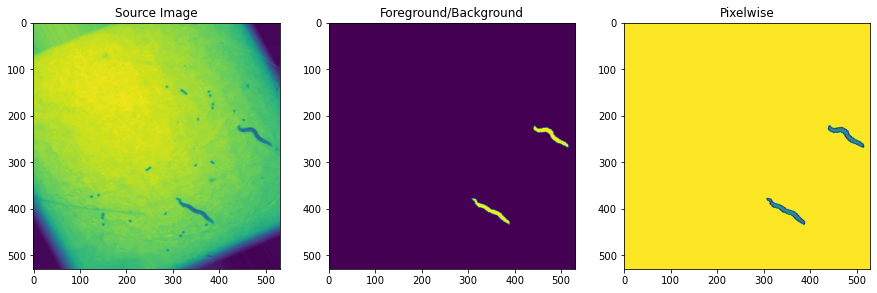

In [22]:
from matplotlib import pyplot as plt

# Different data generators but same data and same seed
img, fgbg_output = fgbg_train_data.next()
_, pixelwise_output = pixelwise_train_data.next()

if n_skips:
    fgbg_output = fgbg_output[0]
    pixelwise_output = pixelwise_output[0]

fig, axes = plt.subplots(1, 3, figsize=(15, 15))
ax = axes.ravel()

ax[0].imshow(img[0, ..., 0])
ax[0].set_title('Source Image')

ax[1].imshow(np.argmax(fgbg_output[0, ...], axis=-1))
ax[1].set_title('Foreground/Background')

ax[2].imshow(np.argmax(pixelwise_output[0, ...], axis=-1))
ax[2].set_title('Pixelwise')

plt.show()

### Compile the model with a loss function

Each model is trained with it's own loss function. `weighted_categorical_crossentropy` is often used for classification models, but `weighted_focal_loss` is also supported. The losses are passed to `model.compile` before training.

In [23]:
from deepcell import losses

def loss_function(y_true, y_pred):
    return losses.weighted_categorical_crossentropy(
        y_true, y_pred,
        n_classes=2,
        from_logits=False)

fgbg_model.compile(
    loss=loss_function,
    optimizer=fgbg_optimizer,
    metrics=['accuracy'])

## Train the foreground/background model

Call `fit()` on the compiled model, along with a default set of callbacks.

In [24]:
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus

model_path = os.path.join(MODEL_DIR, '{}.h5'.format(fgbg_model_name))
loss_path = os.path.join(MODEL_DIR, '{}.npz'.format(fgbg_model_name))

num_gpus = count_gpus()

print('Training on', num_gpus, 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    save_weights_only=num_gpus >= 2,
    monitor='val_loss',
    verbose=1)

loss_history = fgbg_model.fit(
    fgbg_train_data,
    steps_per_epoch=fgbg_train_data.y.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=fgbg_val_data,
    validation_steps=fgbg_val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

loss_history = fgbg_model.fit(
    fgbg_train_data,
    steps_per_epoch=fgbg_train_data.y[0] // batch_size,
    epochs=n_epoch,
    validation_data=fgbg_val_data,
    validation_steps=fgbg_val_data.y[0] // batch_size,
    callbacks=train_callbacks)

Training on 0 GPUs.
Epoch 1/5


AttributeError: in user code:

    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:792 train_step
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    /opt/conda/lib/python3.7/site-packages/keras/engine/compile_utils.py:436 update_state
        self.build(y_pred, y_true)
    /opt/conda/lib/python3.7/site-packages/keras/engine/compile_utils.py:359 build
        self._metrics, y_true, y_pred)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/nest.py:1380 map_structure_up_to
        **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/nest.py:1475 map_structure_with_tuple_paths_up_to
        func(*args, **kwargs) for args in zip(flat_path_gen, *flat_value_gen)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/nest.py:1475 <listcomp>
        func(*args, **kwargs) for args in zip(flat_path_gen, *flat_value_gen)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/nest.py:1378 <lambda>
        lambda _, *values: func(*values),  # Discards the path arg.
    /opt/conda/lib/python3.7/site-packages/keras/engine/compile_utils.py:482 _get_metric_objects
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    /opt/conda/lib/python3.7/site-packages/keras/engine/compile_utils.py:482 <listcomp>
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    /opt/conda/lib/python3.7/site-packages/keras/engine/compile_utils.py:503 _get_metric_object
        y_t_rank = len(y_t.shape.as_list())

    AttributeError: 'tuple' object has no attribute 'shape'


## Create the `pixelwise` FeatureNet Model

Here we instantiate two `FeatureNet` models from `deepcell.model_zoo` for foreground/background separation as well as the interior/edge segmentation.

In [ ]:
pixelwise_model = model_zoo.bn_feature_net_skip_2D(
    fgbg_model=fgbg_model,
    n_features=4 if separate_edge_classes else 3,
    receptive_field=receptive_field,
    norm_method=norm_method,
    n_skips=n_skips,
    n_conv_filters=32,
    n_dense_filters=128,
    last_only=False,
    input_shape=tuple(X_train.shape[1:]))

### Compile the model with a loss function

Just like the foreground/background model, the `pixelwise` model is compiled with the `weighted_categorical_crossentropy` loss function.

In [ ]:
from deepcell import losses

def loss_function(y_true, y_pred):
    return losses.weighted_categorical_crossentropy(
        y_true, y_pred,
        n_classes=4 if separate_edge_classes else 3,
        from_logits=False)

pixelwise_model.compile(
    loss=loss_function,
    optimizer=pixelwise_optimizer,
    metrics=['accuracy'])

## Train the `pixelwise` model

Call `fit()` on the compiled model, along with a default set of callbacks.

In [ ]:
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus

model_path = os.path.join(MODEL_DIR, '{}.h5'.format(pixelwise_model_name))
loss_path = os.path.join(MODEL_DIR, '{}.npz'.format(pixelwise_model_name))

num_gpus = count_gpus()

print('Training on', num_gpus, 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    save_weights_only=num_gpus >= 2,
    monitor='val_loss',
    verbose=1)

loss_history = pixelwise_model.fit(
    pixelwise_train_data,
    steps_per_epoch=pixelwise_train_data.y.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=pixelwise_val_data,
    validation_steps=pixelwise_val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

## Predict on test data

Use the trained model to predict on new data and post-process the results into a label mask.

In [ ]:
test_images = pixelwise_model.predict(X_test)[-1]
test_images_fgbg = fgbg_model.predict(X_test)[-1]

print('watershed transform shape:', test_images.shape)
print('segmentation mask shape:', test_images_fgbg.shape)

#### Post-processing

In [ ]:
# threshold the foreground/background
# and remove back ground from edge transform
threshold = 0.9

fg_thresh = test_images_fgbg[..., 1] > threshold
fg_thresh = np.expand_dims(fg_thresh, axis=-1)

test_images_post_fgbg = test_images * fg_thresh

In [ ]:
# Label interior predictions
from skimage.measure import label
from skimage import morphology

labeled_images = []
for i in range(test_images_post_fgbg.shape[0]):
    interior = test_images_post_fgbg[i, ..., 2] > .2
    labeled_image = label(interior)
    labeled_image = morphology.remove_small_objects(
        labeled_image, min_size=50, connectivity=1)
    labeled_images.append(labeled_image)
labeled_images = np.array(labeled_images)
labeled_images = np.expand_dims(labeled_images, axis=-1)

print('labeled_images shape:', labeled_images.shape)

In [ ]:
import matplotlib.pyplot as plt

index = np.random.randint(low=0, high=X_test.shape[0])
print('Image number:', index)

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, ..., 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_fgbg[index, ..., 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(fg_thresh[index, ..., 0], cmap='jet')
ax[2].set_title('FGBG Threshold {}%'.format(threshold * 100))

ax[3].imshow(test_images[index, ..., 0] + test_images[index, ..., 1], cmap='jet')
ax[3].set_title('Edge Prediction')

ax[4].imshow(test_images[index, ..., 2], cmap='jet')
ax[4].set_title('Interior Prediction')

ax[5].imshow(labeled_images[index, ..., 0], cmap='jet')
ax[5].set_title('Instance Segmentation')

fig.tight_layout()
plt.show()